In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import *
import iminuit
from iminuit import Minuit, describe, Struct
from scipy.interpolate import interp1d
import pandas as pd

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/")
# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
#import PointSource_ExactJ
import PowerLaw

# Siddharth and Laura's Stuff
import constants_noh as constants
import units

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

In [2]:
# Global settings
nside=128
emin = 0
emax = 39

In [113]:
trials = 1000
channel = 'b'
Nb = 2
conc = "SP"
xsec = 1e-21
marr = [10000]
ebins = 2*np.logspace(-1,3,41)[emin:emax+2]
#my_iebins = [ 10, 17, 24, 27 ]
my_iebins = [10, 15]
r_bounds = [20, 180]
#r_bounds = np.arange(0, 181, 5)
print(ebins[my_iebins])


[2.         6.32455532]


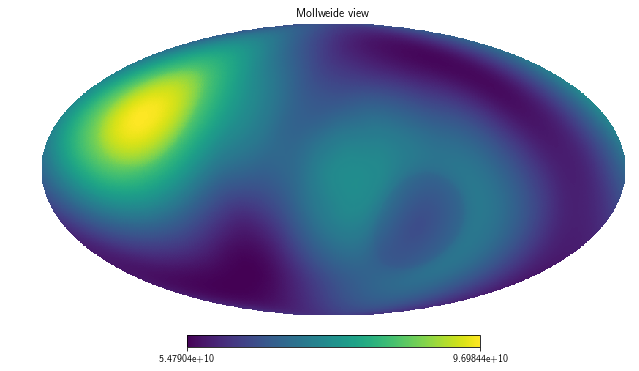

In [114]:
exposure_ebins= []
for ib, b in enumerate(my_iebins[:-1]):
    fermi_exposure = np.zeros(len(np.load("maps/exposure0.npy")))
    n = 0
    for bin_ind in range(b, my_iebins[ib+1]):
        n+=1
        fermi_exposure += np.load("maps/exposure"+str(bin_ind)+".npy")
    fermi_exposure = fermi_exposure / n
    exposure_ebins.append(fermi_exposure)
hp.mollview(fermi_exposure)

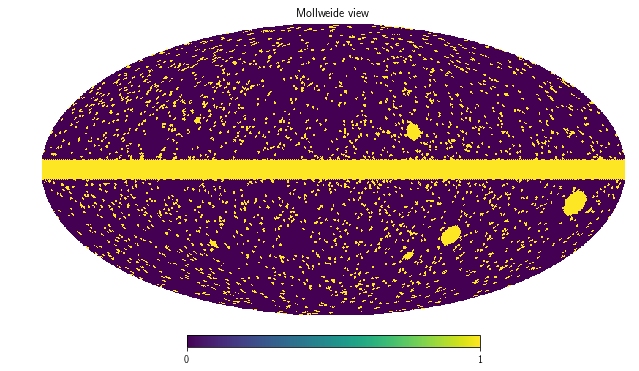

In [115]:
# Setting basic parameters
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('/tigress/somalwar/Subhaloes/Subhalos/fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = False, inner = r_bounds[0], outer = r_bounds[1], custom_mask = pscmask)
#mask = cm.make_mask_total(band_mask = False)
area_rat = (len(mask[~mask]))/len(mask)
hp.mollview(mask)

In [116]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
r_s_NFW = 17
# scale radius [kpc]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 1e-5*M_MW
mMax = .01*M_MW # [M_s]

In [117]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)
N_subs = np.random.poisson( round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) ) # Total number of subhalos

m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 8000) # mass values to test
def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r)**(-1/.9)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, 2000)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

rho_0_NFW = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * 1 / ( (x/r_s_NFW) * (1 + x/r_s_NFW)**2 ), 0, 2000)[0]
def rho_NFW(r): # NFW density profile
    return rho_0_NFW / ( (r/r_s_NFW) * (1 + r/r_s_NFW)**2 )

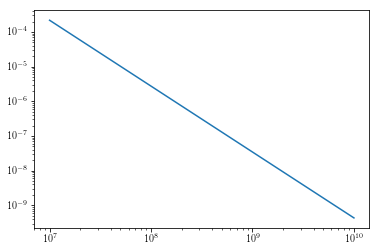

In [118]:
plt.plot(np.logspace(7,10,100), dNdm_func(np.logspace(7, 10, 100)))
plt.yscale("log")
plt.xscale("log")

In [119]:
r_test_arr = np.logspace(0, np.log10(2000), 60500)
cdf_Ein = []
for r in r_test_arr:
    cdf_Ein.append(quad(lambda r: r**2*rho_Ein(r), 0, r)[0])
cdf_NFW = []
for r in r_test_arr:
    cdf_NFW.append(quad(lambda r: r**2*rho_NFW(r), 0, r)[0])

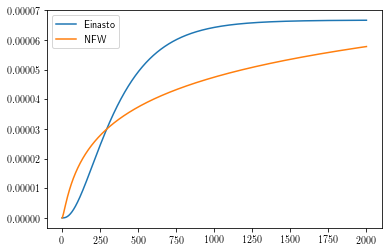

In [120]:
plt.plot(r_test_arr, cdf_Ein/np.sum(cdf_Ein), label="Einasto")
plt.plot(r_test_arr, cdf_NFW/np.sum(cdf_NFW), label="NFW")
plt.legend()

In [121]:
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=N_subs)
#r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_NFW(r), r_arr, nsamples=N_subs)
m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=N_subs, cdfinv=mCDFInv)

In [122]:
PS_arr_ebins = []
F_arr_ebins = []
F_arr_ebins2 = []
PPnoxsec_ebins = []
min_flux_arr = []
PS_arr_ebins2 = []
F_arr_ebins22 = []
F_arr_ebins222 = []
PPnoxsec_ebins2 = []
min_flux_arr2 = []
flux_bins = np.logspace(-15, -6, 8*8)
energy_bins = np.logspace(-12, -7, 1000)
for ib in range(len(my_iebins)-1):
    PS_arr_mask = []
    F_arr_mask = []
    F_arr_mask2 = []
    min_flux_arr_mask = []
    PS_arr_mask2 = []
    F_arr_mask22 = []
    F_arr_mask222 = []
    min_flux_arr_mask2 = []
    for ir in tqdm_notebook(range(len(r_bounds)-1)):
        PS_arr = []
        F_arr = []
        F_arr2 = []
        E_arr = []
        PS_arr2 = []
        F_arr22 = []
        F_arr222 = []
        E_arr2 = []
        mask2 = cm.make_mask_total(mask_ring = True, inner = r_bounds[ir], outer = r_bounds[ir+1], custom_mask = mask)
        min_flux_arr_mask.append(np.log10(1./(np.sum(exposure_ebins[ib][~mask2])/len(exposure_ebins[ib][~mask2]))))
        for i in (range(trials)):
            rval_arr = r_sampler.sample()
            mval_arr = m_sampler.sample()

            theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
            phi_arr = (2*np.pi*np.random.rand(N_subs))

            PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
            PS_set.calcJ(conc)
            PS_arr.append(PS_set)
            if i == 0 and ir == 0: 
                PPnoxsec = PS_set.PPnoxsec(marr[0], [ ebins[my_iebins[ib]], ebins[my_iebins[ib+1]] ], channel)
                PPnoxsec_ebins.append(PPnoxsec)

            F_arr2.append(np.histogram(PS_set.J[~mask2[PS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0])
            PS_set.J[PS_set.J*xsec*PPnoxsec*exposure_ebins[ib][PS_set.pixels] > 1000] = 0
            F_arr.append(np.histogram(PS_set.J[~mask2[PS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0])
                
        PS_arr_mask.append(PS_arr)
        F_arr_mask.append(F_arr)
        F_arr_mask2.append(F_arr2)
    PS_arr_ebins.append(PS_arr_mask)
    F_arr_ebins.append(F_arr_mask)
    F_arr_ebins2.append(F_arr_mask2)
    min_flux_arr.append(min_flux_arr_mask)

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [123]:
min_flux_ind_arr = []
F_ave_arr = []
max_flux_arr = []
dF_arr = []
dN_arr = []
F_arr_arr = []
F_val_arr = []
for ib2 in range(len(my_iebins)-1):
    ib = 0
    min_flux_ind_arr_mask = []
    F_ave_arr_mask = []
    max_flux_arr_mask = []
    dF_arr_mask = []
    dN_arr_mask = []
    F_arr_arr_mask = []
    F_val_arr_mask = []
    for ir in range(len(r_bounds)-1):
        min_flux_ind_arr_mask.append(np.argmin(np.abs(flux_bins - 10.**(min_flux_arr[ib][ir]))))
        flux_bins2 = flux_bins[min_flux_ind_arr_mask[-1]:]
        F_arr = np.array(F_arr_ebins22[ib][ir]).astype(float)
        for i in range(len(F_arr22)):
            F_arr22[i][F_arr22[i]<=1e-30] = 1e-50
        F_arr_arr_mask.append(F_arr22)
        F_ave_arr_mask.append((np.median(F_arr22, axis=0))[min_flux_ind_arr_mask[-1]:])
        max_flux_arr_mask.append(np.log10(flux_bins2[np.argmax(F_ave_arr_mask[-1] < 1e-20)]))
        dF_arr_mask.append(np.diff(flux_bins2))
        dN_arr_mask.append(np.array(F_ave_arr_mask[-1])/(4*np.pi*(180/np.pi)**2*area_rat))
        F_val_arr_mask.append((np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.)
    min_flux_ind_arr.append(min_flux_ind_arr_mask)
    F_ave_arr.append(F_ave_arr_mask)
    max_flux_arr.append(max_flux_arr_mask)
    dF_arr.append(dF_arr_mask)
    dN_arr.append(dN_arr_mask)
    F_arr_arr.append(F_arr_arr_mask)
    F_val_arr.append(F_val_arr_mask)

IndexError: list index out of range

In [124]:
min_flux_ind_arr = []
F_ave_arr = []
max_flux_arr = []
dF_arr = []
dN_arr = []
F_arr_arr = []
F_val_arr = []
for ib2 in range(len(my_iebins)-1):
    ib = 0
    min_flux_ind_arr_mask = []
    F_ave_arr_mask = []
    max_flux_arr_mask = []
    dF_arr_mask = []
    dN_arr_mask = []
    F_arr_arr_mask = []
    F_val_arr_mask = []
    for ir in range(len(r_bounds)-1):
        min_flux_ind_arr_mask.append(np.argmin(np.abs(flux_bins - 10.**(min_flux_arr[ib][ir]))))
        flux_bins2 = flux_bins[min_flux_ind_arr_mask[-1]:]
        F_arr = np.array(F_arr_ebins[ib][ir]).astype(float)
        for i in range(len(F_arr)):
            F_arr[i][F_arr[i]<=1e-30] = 1e-50
        F_arr_arr_mask.append(F_arr)
        F_ave_arr_mask.append((np.median(F_arr, axis=0))[min_flux_ind_arr_mask[-1]:])
        max_flux_arr_mask.append(np.log10(flux_bins2[np.argmax(F_ave_arr_mask[-1] < 1e-20)]))
        dF_arr_mask.append(np.diff(flux_bins2))
        dN_arr_mask.append(np.array(F_ave_arr_mask[-1])/(4*np.pi*(180/np.pi)**2*area_rat))
        F_val_arr_mask.append((np.array(flux_bins2)[:-1]+np.array(flux_bins2)[1:])/2.)
    min_flux_ind_arr.append(min_flux_ind_arr_mask)
    F_ave_arr.append(F_ave_arr_mask)
    max_flux_arr.append(max_flux_arr_mask)
    dF_arr.append(dF_arr_mask)
    dN_arr.append(dN_arr_mask)
    F_arr_arr.append(F_arr_arr_mask)
    F_val_arr.append(F_val_arr_mask)

In [125]:
# print("running")
# best_fit_params = []
# subhalos = np.load('/tigress/somalwar/Subhaloes/Subhalos/MC/EinastoTemplate2.npy')
# subhalos = subhalos/np.mean(subhalos)
# for ib, PS_arr in enumerate(PS_arr_ebins):
#     flux_map_ave = np.zeros(hp.nside2npix(nside))
#     for iP, PS_set in (enumerate(PS_arr)):
#         flux_map = np.zeros(hp.nside2npix(nside))
#         flux = PS_set.J.value * xsec * PPnoxsec_ebins[ib]
#         for ipix, pix in enumerate(PS_set.pixels):
#             flux_map[pix] += flux[ipix]
#         #np.save("/tigress/somalwar/Subhaloes/Subhalos/MC/FixedSCD/subhalo_flux_map_"+str(iP)+"_"+str(my_iebins[ib])+"-"+str(my_iebins[ib+1]), flux_map) 
#         n = nptfit.NPTF(tag='fit')
#         sig = np.round(flux_map * exposure_ebins[ib]).astype(np.int32)

#         n.load_data(sig.copy(), exposure_ebins[ib].copy())
#         n.load_mask(mask) 

#         subhalos_copy = subhalos.copy()
#         n.add_template(subhalos_copy, 'subhalos', units='PS')
# #         n.add_non_poiss_model( 'subhalos',
# #                               ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$', '$n_3$', '$S_b1$', '$S_b2$'],
# #                               [[-10, -3],[2.05, 3],[-3, 3],[-10.0, 0.95],[1,100], [0.1,1]],
# #                               [True,False,False, False, False, False],
# #                               dnds_model='specify_relative_breaks' )

# #         n.configure_for_scan();
# #         print("here")
# #         def ll(A, n1, n2, n3, Fb1, Fb2):
# #             return -n.ll([A, n1, n2, n3, Fb1, Fb2])
# #         minuit_min = iminuit.Minuit(ll, \
# #                                     A=-6, limit_A=(-10,-3), error_A=1e-2, \
# #                                     n1=10, limit_n1=(2.05, 3), error_n1=1e-2, \
# #                                     n2 = 0, limit_n2=(-3, 3), error_n2=1e-2, \
# #                                     n3 = 0.1, limit_n3=(-10, 0.95), error_n3=1e-2, \
# #                                     Fb1 = 60, limit_Fb1=(1, 100), error_Fb1=1e-2, \
# #                                     Fb2 = 0.5, limit_Fb2=(0.1, 1), error_Fb2=1e-3, \
# #                                     print_level=1);

# #         minuit_min.migrad()
# #         max_LL = -minuit_min.fval
# #         best_fit_params.append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['n3'], minuit_min.values['Fb1'], minuit_min.values['Fb2'] ]))
# #         best_fit_params.append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['Fb1'] ]))
#         n.add_non_poiss_model( 'subhalos',
#                               ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$', '$S_b1$'],
#                               [[-10, -1],[2.05, 10],[-10.0, 0.95],[1,100]],
#                               [True, False, False, False])

#         n.configure_for_scan();

#         def ll(A, n1, n2, Fb1):
#             return -n.ll([A, n1, n2, Fb1])
#         minuit_min = iminuit.Minuit(ll, \
#                                     A=-6, limit_A=(-10,-1), error_A=1e-2, \
#                                     n1=10, limit_n1=(2.05, 10), error_n1=1e-2, \
#                                     n2 = 0, limit_n2=(-10, 0.95), error_n2=1e-2, \
#                                     Fb1 = 60, limit_Fb1=(1, 100), error_Fb1=1e-2, \
#                                     print_level=1);

#         minuit_min.migrad()
#         max_LL = -minuit_min.fval
#         best_fit_params.append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['Fb1'] ]))

#         #print("Best Fit Params:", best_fit_params)
#         #print("Max LL:", max_LL)

In [126]:
print("running")
best_fit_params = []
subhalos = np.load('/tigress/somalwar/Subhaloes/Subhalos/MC/EinastoTemplate2.npy')
subhalos = subhalos/np.mean(subhalos)
for ib, PS_arr_mask in enumerate(PS_arr_ebins2):
    print(ib)
    flux_map_ave = np.zeros(hp.nside2npix(nside))
    for ir, PS_arr in enumerate(PS_arr_mask):
        best_fit_params_mask = []
        mask2 = cm.make_mask_total(mask_ring = True, inner = r_bounds[ir], outer = r_bounds[ir+1], custom_mask = mask)
        for iP, PS_set in (enumerate(PS_arr)):
            flux_map = np.zeros(hp.nside2npix(nside))
            flux = PS_set.J * xsec * PPnoxsec_ebins[ib]
            for ipix, pix in enumerate(PS_set.pixels):
                flux_map[pix] += flux[ipix]
                flux_map_ave[pix] += flux[ipix]
        flux_map_ave = np.array(flux_map_ave)/trials
        sig = flux_map*exposure_ebins[ib]
        sig[mask2] = 0
        hp.mollview(np.log10(1e-5+sig))
            #np.save("/tigress/somalwar/Subhaloes/Subhalos/MC/FixedSCD/subhalo_flux_map_"+str(iP)+"_"+str(my_iebins[ib])+"-"+str(my_iebins[ib+1]), flux_map) 
        n = nptfit.NPTF(tag='fit')
        sig = np.load("BlazarsTests/MPITemp/fake_data0_test.npy") #np.round(flux_map * exposure_ebins[ib]).astype(np.int32)
        #hp.mollview(sig)

        n.load_data(sig.copy(), exposure_ebins[ib].copy())
        n.load_mask(mask2.copy()) 

        subhalos_copy = subhalos.copy()
        n.add_template(subhalos_copy, 'subhalos', units='PS')
        n.add_non_poiss_model( 'subhalos',
                              ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$', '$n_3$', '$S_b1$', '$S_b2$'],
                              [[-10, -3],[2.05, 3],[-3, 3],[-1.0, 1.0],[1,100], [0.1,1]],
                              [True,False,False, False, False, False],
                              dnds_model='specify_relative_breaks' )

        n.configure_for_scan();

        def ll(A, n1, n2, n3, Fb1, Fb2):
            return -n.ll([A, n1, n2, n3, Fb1, Fb2])
        minuit_min = iminuit.Minuit(ll, \
                                    A=-6, limit_A=(-10,-3), error_A=1e-2, \
                                    n1=10, limit_n1=(2.05, 3), error_n1=1e-2, \
                                    n2 = 0, limit_n2=(-3, 3), error_n2=1e-2, \
                                    n3 = 0.1, limit_n3=(-10, 0.95), error_n3=1e-2, \
                                    Fb1 = 60, limit_Fb1=(1, 100), error_Fb1=1e-2, \
                                    Fb2 = 0.5, limit_Fb2=(0.1, 1), error_Fb2=1e-3, \
                                    print_level=1);

        #minuit_min.migrad()
        max_LL = -minuit_min.fval
        best_fit_params_mask.append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['n3'], minuit_min.values['Fb1'], minuit_min.values['Fb2'] ]))
        best_fit_params_mask.append( np.array( [minuit_min.values['A'], minuit_min.values['n1'], minuit_min.values['n2'], minuit_min.values['Fb1'] ]))
        #print("Best Fit Params:", best_fit_params)
        #print("Max LL:", max_LL)
    best_fit_params.append(best_fit_params_mask)

running


In [127]:
def convert_SCD_to_powerlaw_form3(best_fit_params):
    best_fit_params = np.array(best_fit_params[0])
    best_fit_params[0] = 10**best_fit_params[0]
    best_fit_params[-2] = best_fit_params[-3]*best_fit_params[-2]
    best_fit_params[-1] = best_fit_params[-2]*best_fit_params[-1]
    best_fit_params = np.array(best_fit_params*np.array([np.average(exposure_ebins[ib][~mask2]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(subhalos[~mask2])), 1., 1., 1., 1., 1/np.average(exposure_ebins[ib][~mask2]), 1/np.average(exposure_ebins[ib][~mask2]), 1/np.average(exposure_ebins[ib][~mask2])]))
    best_fit_params[0] = np.log10(best_fit_params[0])
    best_fit_params[-3:] = np.log10(best_fit_params[-3:])
    best_fit_params[-1] = np.abs(best_fit_params[-2]) + best_fit_params[-1]
    best_fit_params[-2] = np.abs(best_fit_params[-3]) + best_fit_params[-2]
    return best_fit_params

def convert_SCD_to_powerlaw_form2(best_fit_params):
    best_fit_params = np.array(best_fit_params[0])
    best_fit_params[0] = 10**best_fit_params[0]
    best_fit_params[-1] = best_fit_params[-2]*best_fit_params[-1]
    best_fit_params = np.array(best_fit_params*np.array([np.average(exposure_ebins[ib][~mask2]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(subhalos[~mask2])), 1., 1., 1., 1/np.average(exposure_ebins[ib][~mask2]), 1/np.average(exposure_ebins[ib][~mask2])]))
    best_fit_params[0] = np.log10(best_fit_params[0])
    best_fit_params[-2:] = np.log10(best_fit_params[-2:])
    best_fit_params[-1] = np.abs(best_fit_params[-2]) + best_fit_params[-1]
    return best_fit_params

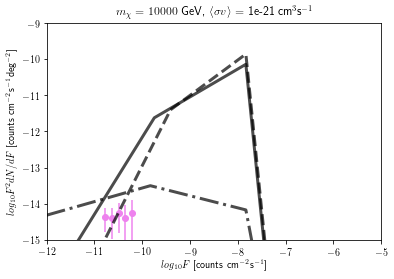

In [128]:
best_fit_params3 = [np.array( [ -5.981396075211702 ,  14.99999999 , 1.228689325 , -0.128016612 , 1000,  0.0121407496 ] )]
best_fit_params2 = [np.array([ -5.6997673097505395 ,  15.0 , 1.02364969 , -0.611767355 , 1000,  0.026330505 ])]
best_fit_params1 = [np.array([-10.0 ,  8.918666049999999 , 2.334626615 , 1.62376057 , 1000,  0.01000002])]
fig = plt.figure()
ax = plt.subplot(111)
for ib, F_arr_mask in enumerate(F_arr_arr):
    for ir, F_arr in enumerate(F_arr_mask):
        mask2 = cm.make_mask_total(mask_ring = True, inner = r_bounds[ir], outer = r_bounds[ir+1], custom_mask = mask)
        F_ave = F_ave_arr[0][ir] #[ib][ir]
        max_flux = max_flux_arr[0][ir] #[ib][ir]
        min_flux = min_flux_arr[0][ir] #[ib][ir]
        dF = dF_arr[ib][ir]
        dN = dN_arr[ib][ir]
        F = F_val_arr[ib][ir]
        min_flux_ind = min_flux_ind_arr[0][ir] #[ib][ir]
        poisson = (trials==1)
        yerr_up = (AssortedFunctions.PandGErrors(F_arr, poisson))[1][min_flux_ind:]
        yerr_dn = (AssortedFunctions.PandGErrors(F_arr, poisson))[0][min_flux_ind:]
        yerr_up = F**2 * yerr_up / dF /(4*np.pi*(180/np.pi)**2*area_rat)
        yerr_dn = F**2 * yerr_dn / dF /(4*np.pi*(180/np.pi)**2*area_rat)

        yerr_up = yerr_up/np.log(10) / (F**2 * dN/dF)
        yerr_dn = yerr_dn/np.log(10) / (F**2 * dN/dF)
        plt.errorbar(myLog(F), myLog(F**2*dN/dF), fmt='o', c="violet", yerr=[yerr_up, yerr_dn], label="Flux Cutoff")   #"["+str(my_iebins[ib])+"," +str(my_iebins[ib+1])+"], ["+str(r_bounds[ir])+","+str(r_bounds[ir+1])+"]")
        F_test = np.logspace(-12,6,5000)

        best_fit_params_med = convert_SCD_to_powerlaw_form2(best_fit_params3)
        plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params_med), zorder=5, linewidth=3, c="black", alpha=0.7, label="Floating Lower Break from [0.01,1]") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))

        best_fit_params_med = convert_SCD_to_powerlaw_form2(best_fit_params2)
        plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params_med), zorder=5, linewidth=3, c="black", alpha=0.7, ls="--", label="Floating Lower Break [0.01, 0.1]") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))

        best_fit_params_med = convert_SCD_to_powerlaw_form2(best_fit_params1)
        plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params_med), zorder=5, linewidth=3, c="black", alpha=0.7, ls="-.", label="Floating Lower Break [0.01, 0.1]") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))

        
#         for SCD in np.load("SCDs.npy"):
#             params = [ SCD[0], SCD[1], SCD[2], SCD[3], SCD[4], 1000, SCD[5], SCD[6] ]
#             plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *convert_SCD_to_powerlaw_form([params])), color="green", alpha=0.01)
        
        #best_fit_params_low = convert_SCD_to_powerlaw_form3(best_fit_params_low)
        #best_fit_params_high = convert_SCD_to_powerlaw_form3(best_fit_params_high)
        #plt.fill_between(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params_low), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params_high), zorder=5, linewidth=3, facecolor="green", alpha=0.1)
ax.set_xlim(-12, -5)
ax.set_ylim(-15, -9)
ax.set_title("$m_{\chi} = "+str(marr[0])+"$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
ax.set_ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
ax.set_xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")

box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_position([box.x0, box.y0, box.width, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.legend()
plt.show()
#plt.close()

(-15, -11)

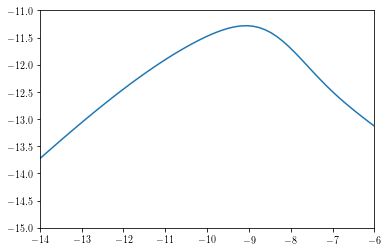

In [156]:
plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params2), zorder=5, linewidth=3, c="blue", alpha=0.3) #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))
file = np.load("/tigress/somalwar/Subhaloes/Subhalos/blazars/blazar_dNdF_10-15.npy")
plt.plot(myLog(file[0]), 2*myLog(file[0])+myLog(file[1]))
plt.xlim(-14, -6)
plt.ylim(-15, -11)

[ 2.0 , 6.32 ]
[ 6.32 , 20.0 ]
4.077560022385731
[-12.41       -12.40891978 -12.40783957 ... -22.55495899 -22.5574795
 -22.56      ]


Text(0.5,1,'Blazars SCD')

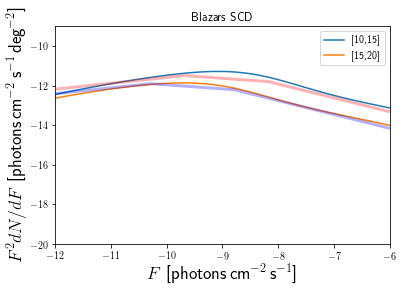

In [157]:
E_bounds = [10,15, 20]
for eb in range(len(E_bounds) - 1):
    print("[",round(ebins[E_bounds[eb]],2),",", round(ebins[E_bounds[eb+1]],2),"]")
    file = np.load("/tigress/somalwar/Subhaloes/Subhalos/blazars/blazar_dNdF_"+str(E_bounds[eb])+"-"+str(E_bounds[eb+1])+".npy")
    plt.plot(myLog(file[0]), 2*myLog(file[0])+myLog(file[1]), label="["+str(E_bounds[eb])+","+str(E_bounds[eb+1])+"]")\
    
E_vals = 2*np.logspace(-1,3,41)[0:41]
dIdE_BL_vals = np.load("/tigress/somalwar/Subhaloes/Subhalos/blazars/blazar_spectrum.npz")['arr_0']
for ib in range(len(E_bounds)-2):
    print( np.trapz(dIdE_BL_vals[E_bounds[ib]:E_bounds[ib+1]], np.array(E_vals[E_bounds[ib]:E_bounds[ib+1]])) / np.trapz(dIdE_BL_vals[E_bounds[-2]:E_bounds[-1]], np.array(E_vals[E_bounds[-2]:E_bounds[-1]])) )
    
F_test = np.logspace(-12,6,5000)
fit = [ 5.4, 2.7, 2.2, 1.7, -8.8, -10.3 ]
fit[-1] = fit[-2]-fit[-1]
scale = 4.077560022385731
fit2 = [ 5.2-np.log10(scale), 2.7, 2.2, 1.7, -8.8+np.log10(scale), -10.3+np.log10(scale) ]
fit2[-1] = fit2[-2]-fit2[-1]
scale2 = .205
fit3 = [ 5.2-np.log10(scale2), 2.7, 2.2, 1.7, -8.8+np.log10(scale2), -10.3+np.log10(scale2) ]
fit3[-1] = fit3[-2]-fit3[-1]
plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *fit), zorder=5, linewidth=3, c="blue", alpha=0.3)
plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *fit2), zorder=5, linewidth=3, c="red", alpha=0.3)
#plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *fit3), zorder=5, linewidth=3, c="purple", alpha=0.3)
print(2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *fit))
plt.xlim(-12,-6)
plt.ylim(-20,-9)
plt.legend()
plt.xlabel('$F$  [photons\,cm$^{-2}$\,s$^{-1}$]', fontsize=18)
plt.ylabel('$F^2 dN/dF$  [photons\,cm$^{-2}$\,s$^{-1}$\,deg$^{-2}$]', fontsize=18)
plt.title("Blazars SCD")

In [ ]:
dNdLogx_df = pd.read_csv('/tigress/somalwar/Subhaloes/Subhalos/Data/AtProduction_gammas.dat', delim_whitespace=True)
DMmass = 100
channel = 'b'

dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(DMmass)))))[['Log[10,x]',channel]]
Egamma = np.array(DMmass*(10**dNdLogx_ann_df['Log[10,x]']))
dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
dNdE_interpd = interp1d(Egamma, dNdEgamma)

In [ ]:
for PS_set in PS_arr[:-1]:
    J_vals = PS_set.J.value
print(np.log10(np.sum(J_vals)))
plt.plot(Egamma, Egamma**2 * 3e-26 / ( 8 * np.pi * 100**2 ) * 1e22 * dNdEgamma / (4*np.pi * area_rat) )
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.ylim(1e-15)
plt.ylabel("$E^2$ dI/dE [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
plt.xlabel("E [GeV]")
plt.title("Subhalos")

In [ ]:
import re
best_fit_params = []
for j in range(600):
    filename = "/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/slurm/slurm"+str(j)+".out"
    time = os.path.getmtime(filename)
    if j == 0: time0 = time
    if time < time0: continue
    file = open(filename, 'r')
    readLine = False
    best_fit_params_i = []
    for line in file:
        if "Best Fit Params" in line: 
            for i in (re.findall(r'[-+]?\d+.\d+', line)):
                best_fit_params_i.append(float(i))
            readLine = True
        elif readLine: 
            for i in (re.findall(r'[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?', line)):
                best_fit_params_i.append(float(i))
            break
    if len(best_fit_params_i) == 6: best_fit_params.append(np.array(best_fit_params_i))
best_fit_params = np.array(best_fit_params)

In [ ]:
A_arr = []
for i in best_fit_params:
    if len(i) == 6: A_arr.append(i[0])
p = plt.plot(A_arr, alpha=0.3)
plt.axhline(np.percentile(A_arr, 50), ls="-", color="black")
plt.axhline(np.percentile(A_arr, 68), ls="-", color=p[0].get_color(), label="A")
plt.axhline(np.percentile(A_arr, 16), ls="-", color=p[0].get_color())
plt.xlabel("Trial Number")
plt.ylabel("A")
plt.title("Subhalo Normalization")
plt.legend()
plt.show()
plt.close()
n1_arr = []
n2_arr = []
n3_arr = []
for i in best_fit_params:
    if len(i) == 6: 
        n1_arr.append(i[1])
        n2_arr.append(i[2])
        n3_arr.append(i[3])
p = plt.plot(n1_arr, alpha=0.3)
plt.axhline(np.percentile(n1_arr, 50), ls="-", color="black")
plt.axhline(np.percentile(n1_arr, 68), ls="-", color=p[0].get_color(), label="$n_1$")
plt.axhline(np.percentile(n1_arr, 16), ls="-", color=p[0].get_color())
p = plt.plot(n2_arr, alpha=0.3)
plt.axhline(np.percentile(n2_arr, 50), ls="-", color="black")
plt.axhline(np.percentile(n2_arr, 68), ls="-", color=p[0].get_color(), label="$n_2$")
plt.axhline(np.percentile(n2_arr, 16), ls="-", color=p[0].get_color())
p = plt.plot(n3_arr, alpha=0.3)
plt.axhline(np.percentile(n3_arr, 50), ls="-", color="black")
plt.axhline(np.percentile(n3_arr, 68), ls="-", color=p[0].get_color(), label="$n_3$")
plt.axhline(np.percentile(n3_arr, 16), ls="-", color=p[0].get_color())
plt.xlabel("Trial Number")
plt.ylabel("n")
plt.title("Subhalo Slopes")
plt.ylim(1.0,2.5)
plt.legend()
plt.show()
plt.close()
Fb1_arr = []
for i in best_fit_params:
    if len(i) == 6: Fb1_arr.append(i[4])
p = plt.plot(Fb1_arr, alpha=0.3)
plt.axhline(np.percentile(Fb1_arr, 50), ls="-", color="black")
plt.axhline(np.percentile(Fb1_arr, 68), ls="-", color=p[0].get_color(), label="$F_{b1}$")
plt.axhline(np.percentile(Fb1_arr, 16), ls="-", color=p[0].get_color())

Fb2_arr = []
for i in best_fit_params:
    if len(i) == 6: Fb2_arr.append(i[5])
Fb2_arr = np.array(Fb2_arr)*np.array(Fb1_arr)
p = plt.plot(Fb2_arr, alpha=0.3)
plt.axhline(np.percentile(Fb2_arr, 50), ls="-", color="black")
plt.axhline(np.percentile(Fb2_arr, 68), ls="-", color=p[0].get_color(), label="$F_{b2}$")
plt.axhline(np.percentile(Fb2_arr, 16), ls="-", color=p[0].get_color())
plt.xlabel("Trial Number")
plt.ylabel("$F_b$")
plt.title("Subhalo Breaks")
plt.ylim(0,90)
plt.legend()
plt.show()
plt.close()
print(repr([np.percentile(A_arr, 50), np.percentile(n1_arr, 50), np.percentile(n2_arr, 50), np.percentile(n3_arr, 50), np.percentile(Fb1_arr, 50), np.percentile(Fb2_arr/Fb1_arr, 50)]))

In [ ]:
def deg_to_kpc(radius, ring_b, ring_l, nside):
    """ Masks outside inner < r < outer, of a ring centred at (ring_b,ring_l)
    """
    mask_none = np.arange(hp.nside2npix(nside))
    return np.logical_not(
           (np.cos(np.radians(inner)) >=
            np.dot(hp.ang2vec(np.radians(90-ring_b),
                   np.radians(ring_l)), hp.pix2vec(nside, mask_none))) *
           (np.dot(hp.ang2vec(np.radians(90-ring_b),
            np.radians(ring_l)), hp.pix2vec(nside, mask_none)) >=
            np.cos(np.radians(outer))))

In [ ]:
test1 = cm.make_mask_total( mask_ring=True, inner=30, outer=100, ring_b=0, ring_l=0,\
                           b_mask = True, b_deg_min=-30, b_deg_max=30,\
                           l_mask = True, l_deg_min=-30, l_deg_max=30)
hp.mollview(test1)

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord
for d in [10, 20, 300]:
    c = SkyCoord(l=5*u.degree, b=5*u.degree, distance=d*u.kpc, frame="galactic")
    print( 5, d, np.sqrt(c.galactocentric.x**2 + c.galactocentric.y**2 + c.galactocentric.z**2))
    c = SkyCoord(l=10*u.degree, b=10*u.degree, distance=d*u.kpc, frame="galactic")
    print( 10, d, np.sqrt(c.galactocentric.x**2 + c.galactocentric.y**2 + c.galactocentric.z**2))
    c = SkyCoord(l=20*u.degree, b=20*u.degree, distance=d*u.kpc, frame="galactic")
    print( 20, d, np.sqrt(c.galactocentric.x**2 + c.galactocentric.y**2 + c.galactocentric.z**2))